## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [24]:
import os
import tensorflow.keras as keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
!nvidia-smi

Tue Dec  3 16:07:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    57W / 149W |   1180MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [0]:
# 載入 Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
- **factor**: 学习速率被降低的因数。新的学习速率 = 学习速率 * 因数
- **patience**: 没有进步的训练轮数，在这之后训练速率会被降低。
"""
reduce_lr_factor = [0.5, 0.6]
redice_lr_patient = [5, 3]

In [31]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %s, reduce_factor: %.2f, reduce_patient: %i" % (model.optimizer.get_config()["name"], reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("opt-%s__f-%s__p-%s" % (model.optimizer.get_config()["name"], reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: RMSprop, reduce_factor: 0.50, reduce_patient: 5
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_108 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_109 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____________________________________________________________

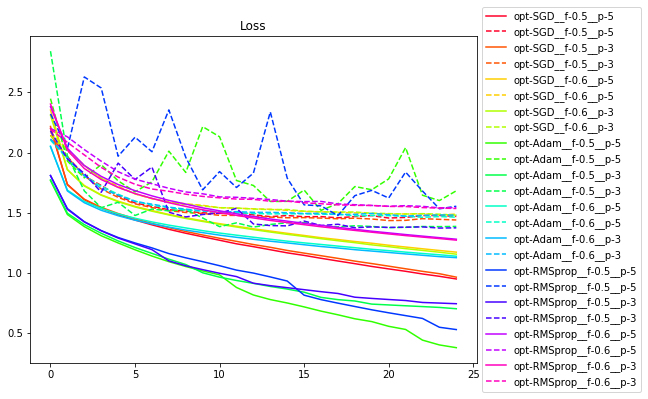

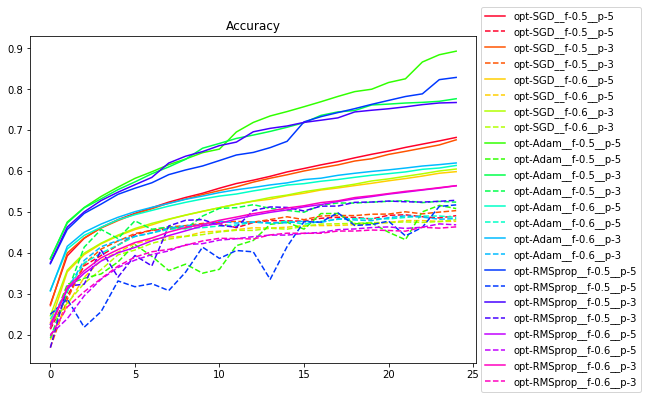

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()